In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform

In [2]:
data_path = "./data/data_with_human_TE_cellline_all_plain.csv"
df = pd.read_csv(data_path, delimiter="\t")
df.head()

,SYMBOL,transcript_id,gene_id,tx_size,utr5_size,cds_size,utr3_size,tx_sequence,bio_source_108T,bio_source_12T,...,struct_max_stem_len_UTR5,struct_max_loop_len_UTR5,struct_min_dG_CDS,struct_n_hairpins_CDS,struct_n_bifurc_CDS,struct_n_bulges_CDS,struct_start_stem_CDS,struct_max_stem_len_CDS,struct_max_loop_len_CDS,fold
0,SAMD11,ENST00000342066.8,ENSG00000187634.12,2557,90,2046,421,GCAGAGCCCAGCAGATCCCTGCGGCGTTCGCGAGGGTGGGACGGGA...,-3.644472,0.986720,...,10.0,5.0,-13.9,2.0,1.0,0.0,9.0,4.0,4.0,4
1,NOC2L,ENST00000327044.7,ENSG00000188976.11,2757,16,2250,491,GCTTCGGGTTGGTGTCATGGCAGCTGCGGGGAGCCGCAAGAGGCGC...,1.060190,0.701399,...,10.0,6.0,-24.5,1.0,0.0,0.0,21.0,10.0,6.0,8
2,KLHL17,ENST00000338591.8,ENSG00000187961.14,2567,110,1929,528,GGGAGTGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCTCC...,-1.198005,-1.178952,...,10.0,4.0,-23.0,1.0,1.0,1.0,3.0,9.0,5.0,9
3,HES4,ENST00000304952.11,ENSG00000188290.11,885,124,666,95,GCGGGCCTGGAGCCGGGATCCGCCCTAGGGGCTCGGATCGCCGCGC...,-1.107400,0.158079,...,16.0,3.0,-24.8,1.0,0.0,0.0,3.0,11.0,3.0,7
4,ISG15,ENST00000649529.1,ENSG00000187608.10,637,77,498,62,GGCGGCTGAGAGGCAGCGAACTCATCTTTGCCAGTACAGGAGCTTG...,0.631561,2.013887,...,8.0,5.0,-28.6,1.0,0.0,2.0,2.0,13.0,5.0,2


In [3]:
#number of unique cell lines -- number of columns that have "bio_source" in the name

print("Number of columns: ", len(df.columns))
print("Number of rows: ", len(df))

na_rows = df[df.isna().any(axis=1)]
print("Number of rows that have NA: ", len(na_rows))

bio_source_cols = [col for col in df.columns if 'bio_source' in col]
print(f"Number of unique human cell lines: {len(bio_source_cols)}")

Number of columns:  102
Number of rows:  11153
Number of rows that have NA:  354
Number of unique human cell lines: 78


In [4]:
#fill in the null values
df = df.dropna()
na_rows = df[df.isna().any(axis=1)]
print("Number of rows that have NA: ", len(na_rows))
print("Number of rows: ", len(df))
df.head()


Number of rows that have NA:  0
Number of rows:  10799


,SYMBOL,transcript_id,gene_id,tx_size,utr5_size,cds_size,utr3_size,tx_sequence,bio_source_108T,bio_source_12T,...,struct_max_stem_len_UTR5,struct_max_loop_len_UTR5,struct_min_dG_CDS,struct_n_hairpins_CDS,struct_n_bifurc_CDS,struct_n_bulges_CDS,struct_start_stem_CDS,struct_max_stem_len_CDS,struct_max_loop_len_CDS,fold
0,SAMD11,ENST00000342066.8,ENSG00000187634.12,2557,90,2046,421,GCAGAGCCCAGCAGATCCCTGCGGCGTTCGCGAGGGTGGGACGGGA...,-3.644472,0.986720,...,10.0,5.0,-13.9,2.0,1.0,0.0,9.0,4.0,4.0,4
1,NOC2L,ENST00000327044.7,ENSG00000188976.11,2757,16,2250,491,GCTTCGGGTTGGTGTCATGGCAGCTGCGGGGAGCCGCAAGAGGCGC...,1.060190,0.701399,...,10.0,6.0,-24.5,1.0,0.0,0.0,21.0,10.0,6.0,8
2,KLHL17,ENST00000338591.8,ENSG00000187961.14,2567,110,1929,528,GGGAGTGAGCGACACAGAGCGGGCCGCCACCGCCGAGCAGCCCTCC...,-1.198005,-1.178952,...,10.0,4.0,-23.0,1.0,1.0,1.0,3.0,9.0,5.0,9
3,HES4,ENST00000304952.11,ENSG00000188290.11,885,124,666,95,GCGGGCCTGGAGCCGGGATCCGCCCTAGGGGCTCGGATCGCCGCGC...,-1.107400,0.158079,...,16.0,3.0,-24.8,1.0,0.0,0.0,3.0,11.0,3.0,7
4,ISG15,ENST00000649529.1,ENSG00000187608.10,637,77,498,62,GGCGGCTGAGAGGCAGCGAACTCATCTTTGCCAGTACAGGAGCTTG...,0.631561,2.013887,...,8.0,5.0,-28.6,1.0,0.0,2.0,2.0,13.0,5.0,2


In [5]:
bio_source_cols = [col for col in df.columns if 'bio_source' in col]
bio_source_df = df[bio_source_cols]
bio_source_df.columns = bio_source_df.columns.str.replace('bio_source_', '')

In [6]:
spearman_corr = bio_source_df.corr(method='spearman')
print("Dimensions of spearman correlation matrix: ", spearman_corr.shape)

Dimensions of spearman correlation matrix:  (78, 78)


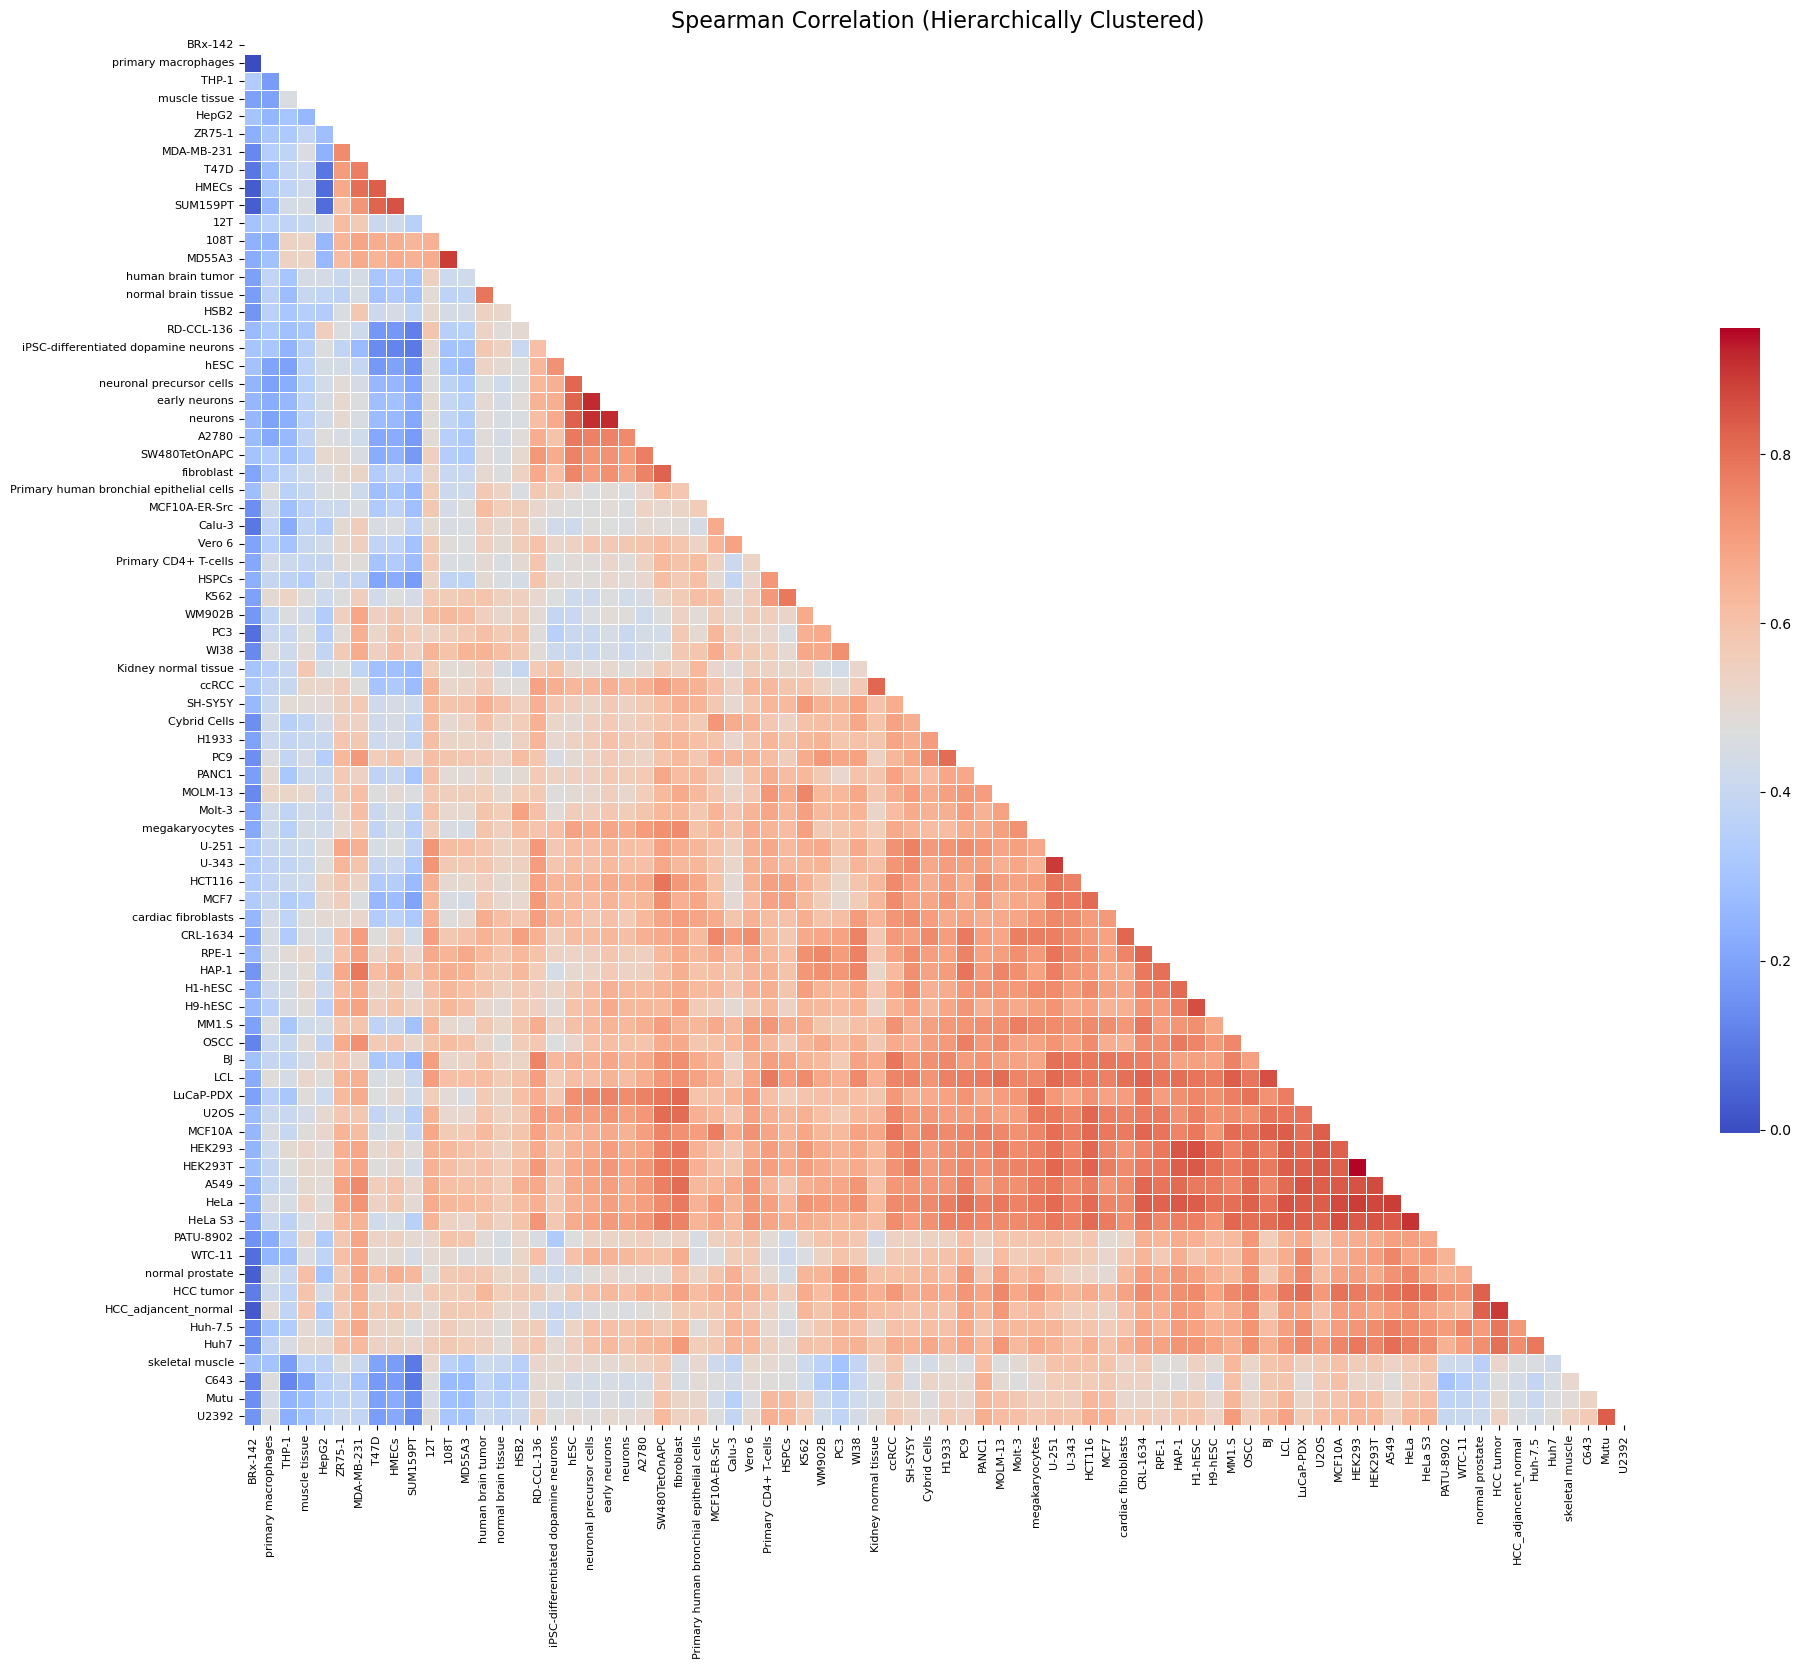

In [7]:
distance_matrix = 1 - spearman_corr
condensed_dist = squareform(distance_matrix.values)
linkage_matrix = linkage(condensed_dist, method='average')

ordered_indices = leaves_list(linkage_matrix)
ordered_corr = spearman_corr.iloc[ordered_indices, ordered_indices]

mask = np.triu(np.ones_like(ordered_corr, dtype=bool))

plt.figure(figsize=(20, 18))
sns.heatmap(
    ordered_corr, 
    mask=mask, 
    cmap='coolwarm', 
    annot=False, 
    fmt=".2f",
    linewidths=0.5, 
    square=True, 
    cbar_kws={"shrink": 0.5}
)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Spearman Correlation (Hierarchically Clustered)", fontsize=16)
plt.tight_layout()
plt.savefig('spearman_correlation_heatmap.png')
plt.show()


In [8]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [9]:
# train linear regression using solely the bio_source
# Filter columns for inputs (columns 3:6) and outputs (columns starting with 'bio_source_')
input_columns = df.iloc[:, 3:7]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_columns, bio_source_df, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
print(y_pred.shape)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display coefficients for each input feature
coefficients = pd.DataFrame(model.coef_, columns=input_columns.columns, index=bio_source_df.columns)
print("Coefficients:")
print(coefficients)

(2160, 78)
Mean Squared Error: 1.0474291285624129
Coefficients:
                      tx_size  utr5_size  cds_size  utr3_size
108T                -0.000253  -0.000566  0.000035   0.000277
12T                 -0.000186  -0.000325 -0.000078   0.000217
A2780               -0.000145  -0.000143 -0.000109   0.000107
A549                -0.000168  -0.000263 -0.000066   0.000161
BJ                  -0.000200  -0.000327 -0.000050   0.000176
...                       ...        ...       ...        ...
neurons             -0.000186  -0.000261 -0.000063   0.000139
normal brain tissue -0.000132  -0.000204 -0.000219   0.000292
normal prostate     -0.000182  -0.000358 -0.000021   0.000196
primary macrophages -0.000070  -0.000086 -0.000075   0.000091
skeletal muscle     -0.000248  -0.000215 -0.000198   0.000165

[78 rows x 4 columns]


In [14]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
import torch.nn as nn

# Function to split a sequence into 3-mers
def tokenize_sequence(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Extract the tx_sequence column
sequences = df['tx_sequence']

# # Tokenize each sequence into 3-mers
tokenized_sequences = sequences.apply(tokenize_sequence)

# Create a vocabulary of unique 3-mers and map them to indices
unique_kmers = set(kmer for seq in tokenized_sequences for kmer in seq)
kmer_to_index = {kmer: idx for idx, kmer in enumerate(unique_kmers)}

# Define the embedding layer
vocab_size = len(kmer_to_index)
embedding_dim = 50  # You can adjust the embedding dimension
embedding_layer = nn.Embedding(vocab_size, embedding_dim)

# Convert each sequence of 3-mers into embeddings
def sequence_to_embeddings(sequence):
    encoded_sequence = [kmer_to_index[kmer] for kmer in sequence]
    encoded_sequence_tensor = torch.tensor(encoded_sequence, dtype=torch.long)
    return embedding_layer(encoded_sequence_tensor).detach().numpy()

# Map each sequence to its embeddings
bio_source_df['embeddings'] = tokenized_sequences.apply(sequence_to_embeddings)

# Example: Access embeddings for the first sequence
print(bio_source_df['embeddings'].iloc[0])

# Uses too much memory - Flatten the list of 3-mers and encode them as integers
# all_kmers = [kmer for seq in tokenized_sequences for kmer in seq]
# label_encoder = LabelEncoder()
# encoded_kmers = label_encoder.fit_transform(all_kmers)

/var/folders/5g/fvsgrw9x65dcl9pg760wxnb00000gn/T/ipykernel_3407/630106936.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bio_source_df['embeddings'] = tokenized_sequences.apply(sequence_to_embeddings)


[[-0.75964695 -0.5024078   0.9996437  ... -1.5887574   0.9715764
   1.2334113 ]
 [ 0.7937543  -0.2738674   3.3570383  ... -1.1621602   0.4501227
  -0.44857195]
 [ 1.1671162   1.2739199  -0.5783854  ...  1.0773946  -0.434999
   1.0271201 ]
 ...
 [ 1.1409541   1.1091533  -0.11378256 ... -1.1698866  -0.04234395
   1.4161912 ]
 [ 0.78899235 -0.7524541  -0.19959703 ... -0.4141775   1.4815795
   0.24982345]
 [ 0.9205829   1.5394222   0.9175883  ...  0.38033906  0.43616605
   0.9609905 ]]


In [ ]:
# # Create a mapping from 3-mers to embeddings
# vocab_size = len(label_encoder.classes_)
# embedding_dim = 50  # You can adjust the embedding dimension
# embedding_layer = nn.Embedding(vocab_size, embedding_dim)

# # Convert each sequence of 3-mers into embeddings
# def sequence_to_embeddings(sequence):
#     encoded_sequence = label_encoder.transform(sequence)
#     encoded_sequence_tensor = torch.tensor(encoded_sequence, dtype=torch.long)
#     return embedding_layer(encoded_sequence_tensor).detach().numpy()

# # Map each sequence to its embeddings
# bio_source_df['embeddings'] = tokenized_sequences.apply(sequence_to_embeddings)

# # Example: Access embeddings for the first sequence
# print(bio_source_df['embeddings'].iloc[0])